In [1]:
# code adapted from https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33#:~:text=The%20Keras%20ResNet%20got%20to,to%20do%20with%20weight%20initializations.
# import plaidml
# import plaidml.keras
# plaidml.install_backend()
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
    
import random
random.seed(10)

from PIL import Image
from glob import glob

# Clean Script
from glob import glob
import tensorflow as tf

from tensorflow.keras.utils import load_img

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model,load_model
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Collect paths to images based on label
nonCancerPaths = glob('imagedata/*/0/*.png')
cancerousPaths = glob('imagedata/*/1/*.png')

# Turn filepaths into image arrays to train a model
def paths_to_image(paths, label, num_samples):
    images = []
    labels = []
    for path in paths[0:num_samples]:
        image = load_img(path)
        image = image.resize([50, 50])
        imgArray = tf.keras.utils.img_to_array(image)
        images.append(imgArray)
        labels.append(label)
    return [images[0: num_samples], labels[0: num_samples]]
nonCancerImages = paths_to_image(nonCancerPaths, 0, len(nonCancerPaths))
cancerImages = paths_to_image(cancerousPaths, 1, len(cancerousPaths))










2023-04-02 07:32:16.014073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# split images into train, val, test
allImages = nonCancerImages[0] + cancerImages[0]
allLabels = nonCancerImages[1] + cancerImages[1]

x_train, x_toSplit, y_train, y_toSplit = train_test_split(allImages, allLabels, test_size=.5, stratify= allLabels, random_state = 10)
x_val, x_test, y_val, y_test = train_test_split(x_toSplit, y_toSplit, test_size=.5, stratify=y_toSplit, random_state = 10)


#function which rotates image a certain number of degrees = to rotation
def rotate_image(X, y, rotation, num_to_rotate = None):
    rotatedImages = []
    labels = []
    cancerX = X[y==1]
    if num_to_rotate is not None and num_to_rotate < len(cancerX):
        cancerX = cancerX[0: num_to_rotate]
    for img in cancerX:
        image = tf.keras.utils.array_to_img(img)
        image = image.resize([50, 50])
        rotateimg = image.rotate(rotation)
        imgArray = tf.keras.utils.img_to_array(rotateimg)
        rotatedImages.append(imgArray)
        labels.append(1)
    return [rotatedImages, labels]


train90 = rotate_image(np.array(x_train), np.array(y_train), 90)
train180 = rotate_image(np.array(x_train), np.array(y_train), 180, 20583)


In [3]:
print("Number of cancer images in training set", str((len(train180[0]) + len(train90[0])) + sum(y_train)))
print("Number of benign images in training set", str(len(y_train) - sum(y_train)))

Number of cancer images in training set 99369
Number of benign images in training set 99369


In [4]:
x_train = np.array(x_train)
train90[0] = np.array(train90[0])
train180[0] = np.array(train180[0])
y_train = np.array(y_train)
train90[1] = np.array(train90[1])
train180[1] = np.array(train180[1])

training_x = np.concatenate((x_train, train90[0], train180[0]), axis=0)
training_y = np.concatenate((y_train, train90[1], train180[1]))


# Shuffle order
zipper = list(zip(training_x, training_y))
random.shuffle(zipper)
training_x, training_y = zip(*zipper)

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(training_x)

# Because of computing power problems we subset to the first 20000 images in training
training_x = training_x[0:20000]
training_y = training_y[0:20000]

train_iterator = datagen.flow(np.array(training_x), np.array(training_y))
val_iterator = datagen.flow(np.array(x_val), np.array(y_val))


2023-04-02 07:41:00.141178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


FITTING
Epoch 1/15
625/625 [==============================] - 833s 1s/step - loss: 0.4860 - accuracy: 0.7736 - val_loss: 0.4409 - val_accuracy: 0.7981
Epoch 2/15
625/625 [==============================] - 808s 1s/step - loss: 0.4090 - accuracy: 0.8184 - val_loss: 0.4482 - val_accuracy: 0.7907
Epoch 3/15
625/625 [==============================] - 813s 1s/step - loss: 0.3725 - accuracy: 0.8400 - val_loss: 0.5366 - val_accuracy: 0.7690
Epoch 4/15
625/625 [==============================] - 807s 1s/step - loss: 0.3274 - accuracy: 0.8567 - val_loss: 0.4508 - val_accuracy: 0.7983
Epoch 5/15
625/625 [==============================] - 810s 1s/step - loss: 0.3120 - accuracy: 0.8640 - val_loss: 0.4064 - val_accuracy: 0.8075
Epoch 6/15
625/625 [==============================] - 810s 1s/step - loss: 0.2851 - accuracy: 0.8766 - val_loss: 0.4274 - val_accuracy: 0.8207
Epoch 7/15
625/625 [==============================] - 813s 1s/step - loss: 0.2701 - accuracy: 0.8841 - val_loss: 0.3645 - val_accuracy

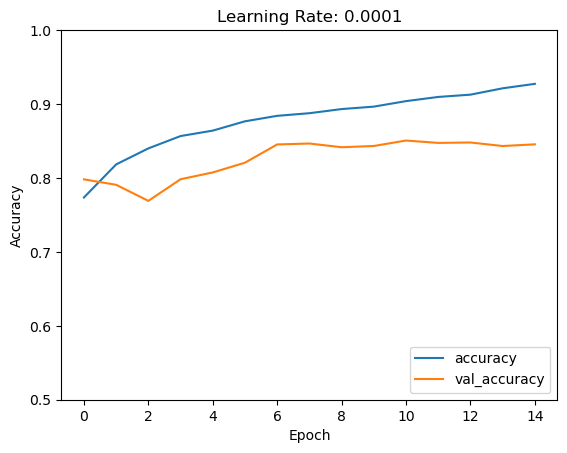

INFO:tensorflow:Assets written to: April1AB20k2023/assets


INFO:tensorflow:Assets written to: April1AB20k2023/assets


In [5]:
# #Learning rates above .01 are not useful
import keras.backend as K

# learning_rates = [.0001, .0005, .001, .005, .01, .05, .1]

# for lr in learning_rates:
#     model = VGG16(weights=None, include_top=True, input_shape= (50, 50,3), classes=2, classifier_activation='softmax')
#     adam = Adam(learning_rate=lr)
#     model.compile(optimizer= adam, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

#     print("FITTING")
#     history = model.fit(np.array(x_train), np.array(y_train), epochs=10, validation_data=(np.array(x_test), np.array(y_test)))
#     plt.plot(history.history['accuracy'], label='accuracy')
#     plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.ylim([0.5, 1])
#     plt.legend(loc='lower right')
#     plt.title("Learning Rate: " + str(lr))
#     plt.show()

# The model outputs a value between 0 and 1, which can be thought of as a probability of being a cancer or not
# model.predict to find the pseudo probability which is a measure of confidence
# we can output the score and the prediction
# activation map to find the feature


# LR = .0001 achieves the highest validation accuracy
# Increase number of epochs to see if more epochs further increases val error
LR = .0001
model = VGG16(weights=None, include_top=True, input_shape= (50, 50,3), classes=2, classifier_activation='softmax')
adam = Adam(learning_rate=LR)
model.compile(optimizer= adam, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

print("FITTING")
history = model.fit(train_iterator, epochs=15, validation_data=val_iterator)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Learning Rate: " + str(LR))
plt.show()

model.save("April1AB20k2023")



In [6]:
# LR = .0001 achieves the highest validation accuracy
# Increase number of epochs to see if more epochs further increases val error
# model = VGG16(weights=None, include_top=True, input_shape= (50, 50,3), classes=2, classifier_activation='softmax')
# adam = Adam(learning_rate=.0001)
# model.compile(optimizer= adam, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# print("FITTING")
# history = model.fit(np.array(x_train), np.array(y_train), epochs=15, validation_data=(np.array(x_test), np.array(y_test)))
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')
# plt.title("Learning Rate: " + str(lr))
# plt.show()


In [7]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [8]:
test_iterator = datagen.flow(np.array(x_test), np.array(y_test))

model.evaluate(test_iterator)

2169/2169 [==============================] - 301s 139ms/step - loss: 0.4283 - accuracy: 0.8425


[0.42833206057548523, 0.8424640893936157]

In [9]:
# cancer evaluation
cancer_iterator = datagen.flow(np.array(np.array(x_test)[np.array(y_test) == 1]), np.array(y_test)[np.array(y_test) == 1])

model.evaluate(cancer_iterator)

616/616 [==============================] - 84s 137ms/step - loss: 0.7919 - accuracy: 0.7537


[0.7918660044670105, 0.7537188529968262]

In [10]:
# benign evaluation

benign_iterator = datagen.flow(np.array(np.array(x_test)[np.array(y_test) == 0]), np.array(y_test)[np.array(y_test) == 0])

model.evaluate(benign_iterator)




1553/1553 [==============================] - 214s 138ms/step - loss: 0.2842 - accuracy: 0.8776


[0.2842101454734802, 0.8776467442512512]

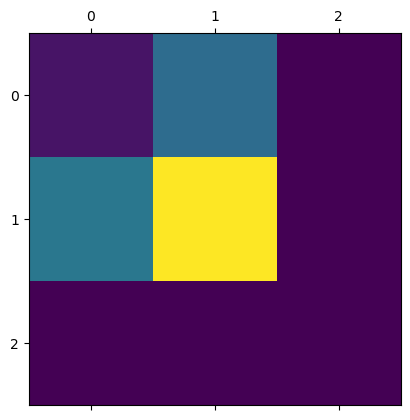

In [29]:


## the penalty of missing a cancer is 2 million dollars * .05 100000
## the penalty of diagnosing a cancer when it isn't there is lets say 20000
import keras
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_size = (50, 50)
path = "imagedata/10253/0/10253_idx5_x1001_y1001_class0.png"
heatmap = make_gradcam_heatmap(datagen.flow(get_img_array(path, img_size))[0], model, "block5_conv3")
plt.matshow(heatmap)
plt.show()

In [33]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(path, heatmap)

/var/folders/bj/cqz9v_7s4pxcpym130bfjj0w0000gr/T/ipykernel_71971/565374863.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


AttributeError: module 'keras.preprocessing.image' has no attribute 'img_to_array'